In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install flax optax jetnet
# ! pip install flash_attention_jax""
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict

import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm
from models.train_utils import create_input_iter, param_count, StateStore, train_step

%load_ext autoreload
%autoreload 2

2023-01-26 18:39:07.939204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-26 18:39:07.939300: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-26 18:39:07.939310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
import numpy as vnp

def generate_mnist_pointclouds(dataset, num_points=100, threshold=50):
    # Create a 1-dimensional array of pixels across all images
    img_ids, y_pixels, x_pixels = np.nonzero(dataset > threshold)
    pixels = np.column_stack((x_pixels, 28 - y_pixels))
    
    # Determine the starting pixel index of each image
    img_ids, pixel_counts = np.unique(img_ids, return_counts=True)
    pixel_index_offsets = np.roll(np.cumsum(pixel_counts), 1)
    pixel_index_offsets.at[0].set(0)
    
    # Generate random pixel indices for each image. (len_dataset, num_points)
    random_pixel_indices = vnp.random.uniform(size=(num_points, dataset.shape[0]))
    pixel_indices = np.floor(pixel_counts[img_ids]*random_pixel_indices).astype(dtype=int).T
    pixel_indices += pixel_index_offsets.reshape(-1, 1)
    
    # Generate the point clouds
    points = pixels[pixel_indices].astype(float)
    points += vnp.random.uniform(size=points.shape)
    
    return points

num_points = 500
threshold = 50

(x_train_img, y_train), (x_test_img, y_test) = tf.keras.datasets.mnist.load_data()

x_train = generate_mnist_pointclouds(x_train_img, num_points, threshold)

In [4]:
x_train_mean = x_train.mean((0,1))
x_train_std = x_train.std((0,1))

x_train = (x_train - x_train_mean) / x_train_std

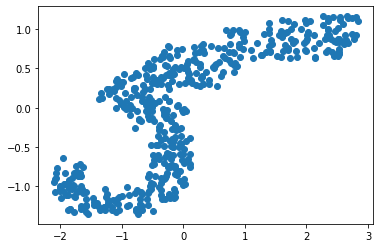

In [5]:
import matplotlib.pyplot as plt
plt.scatter(*x_train[65].T)

In [6]:
batch_size = 32 * jax.device_count()
n_train = len(x_train)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train[:, None]))
train_ds = train_ds.cache()
train_ds = train_ds.repeat()

batch_dims=[jax.local_device_count(), batch_size // jax.device_count()]

for batch_size in reversed(batch_dims):
      train_ds = train_ds.batch(batch_size, drop_remainder=False)

train_ds = train_ds.shuffle(n_train, seed=42)
train_df = create_input_iter(train_ds)

In [22]:
transformer_dict = FrozenDict({"d_model":64, "d_mlp":256, "n_layers":3, "n_heads":2, "flash_attention":True})

vdm = VariationalDiffusionModel(gamma_min=-6.0, 
          gamma_max=6.0, 
          n_layers=4, 
          d_embedding=16,
          d_hidden_encoding=256,
          timesteps=500, 
          d_t_embedding=8,
          d_feature=2,
          latent_diffusion=True,
          transformer_dict=transformer_dict,
          antithetic_time_sampling=False,
          n_classes=10)

In [23]:
n_smoke = 4

batch = np.array(x_train[:n_smoke])
conditioning = np.zeros((n_smoke, y_train.shape[-1]))

In [24]:
rng = jax.random.PRNGKey(42)
out, params = vdm.init_with_output({"sample": rng, "params": rng, "uncond":rng}, batch, np.ones_like(conditioning));

In [25]:
print(f"Params: {param_count(params):,}")

Params: 21,869,938


In [26]:
# CHANGE LOSS TO NOT ACCEPT MASK
loss_vdm(params, vdm, rng, batch, np.zeros_like(conditioning))

Array(1156339.2, dtype=float32)

In [27]:
train_steps = 40_000 // jax.device_count()

opt = optax.chain(
    optax.scale_by_schedule(optax.cosine_decay_schedule(1.0, train_steps, 1e-5)),
    optax.adamw(8e-4, weight_decay=1e-4),
    optax.scale_by_schedule(optax.linear_schedule(0.0, 1.0, 2000)))

store = StateStore(params, opt.init(params), rng, 0)
pstore = replicate(store)

In [28]:
from functools import partial

@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(1, 2, 4))
def train_step(store, loss_fn, model, batch, opt):
    """Train for a single step."""
    rng, spl = jax.random.split(store.rng)
    im, lb = batch
    out, grads = jax.value_and_grad(loss_fn)(store.params, model, spl, im, lb)
    grads = jax.lax.pmean(grads, "batch")
    updates, state = opt.update(grads, store.state, store.params)
    params = optax.apply_updates(store.params, updates)

    return (store.replace(params=params, state=state, rng=rng, step=store.step + 1), jax.lax.pmean(out, "batch"))

In [29]:
batches = create_input_iter(train_ds)

vals = []
with trange(train_steps) as t:
    for i in t:
        pstore, val = train_step(pstore, loss_vdm, vdm, next(batches), opt)
        v = unreplicate(val)
        t.set_postfix(val=v)
        vals.append(v)

100%|██████████| 40000/40000 [17:33<00:00, 37.98it/s, val=41.95782]    


## Conditional generation

In [30]:
from models.diffusion_utils import sigma2

In [31]:
def generate(vdm, params, rng, shape, conditioning, mask=None):
    """Generate samples from a VDM model."""

    # Generate latents
    rng, spl = jax.random.split(rng)
    zt = jax.random.normal(spl, shape + (vdm.d_embedding,))

    def body_fn(i, z_t):
        return vdm.apply(params, rng, i, vdm.timesteps, z_t, conditioning, mask=mask, method=vdm.sample_step)

    z0 = jax.lax.fori_loop(lower=0, upper=vdm.timesteps, body_fun=body_fn, init_val=zt)

    g0 = vdm.apply(params, 0.0, method=vdm.gammat)
    var0 = sigma2(g0)
    z0_rescaled = z0 / np.sqrt(1.0 - var0)
    return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)

In [34]:
n_samples = 16
idx_rnd = vnp.random.choice(vnp.arange(len(y_train)), size=n_samples, replace=False)

# cond = (np.arange(n_samples) % 10)[:, None]
cond = 0 * np.ones((n_samples,1))

rng = jax.random.PRNGKey(6)
x_samples = generate(vdm, unreplicate(pstore).params, rng, (n_samples, int(num_points)), cond)
x_samples = x_samples.mean()

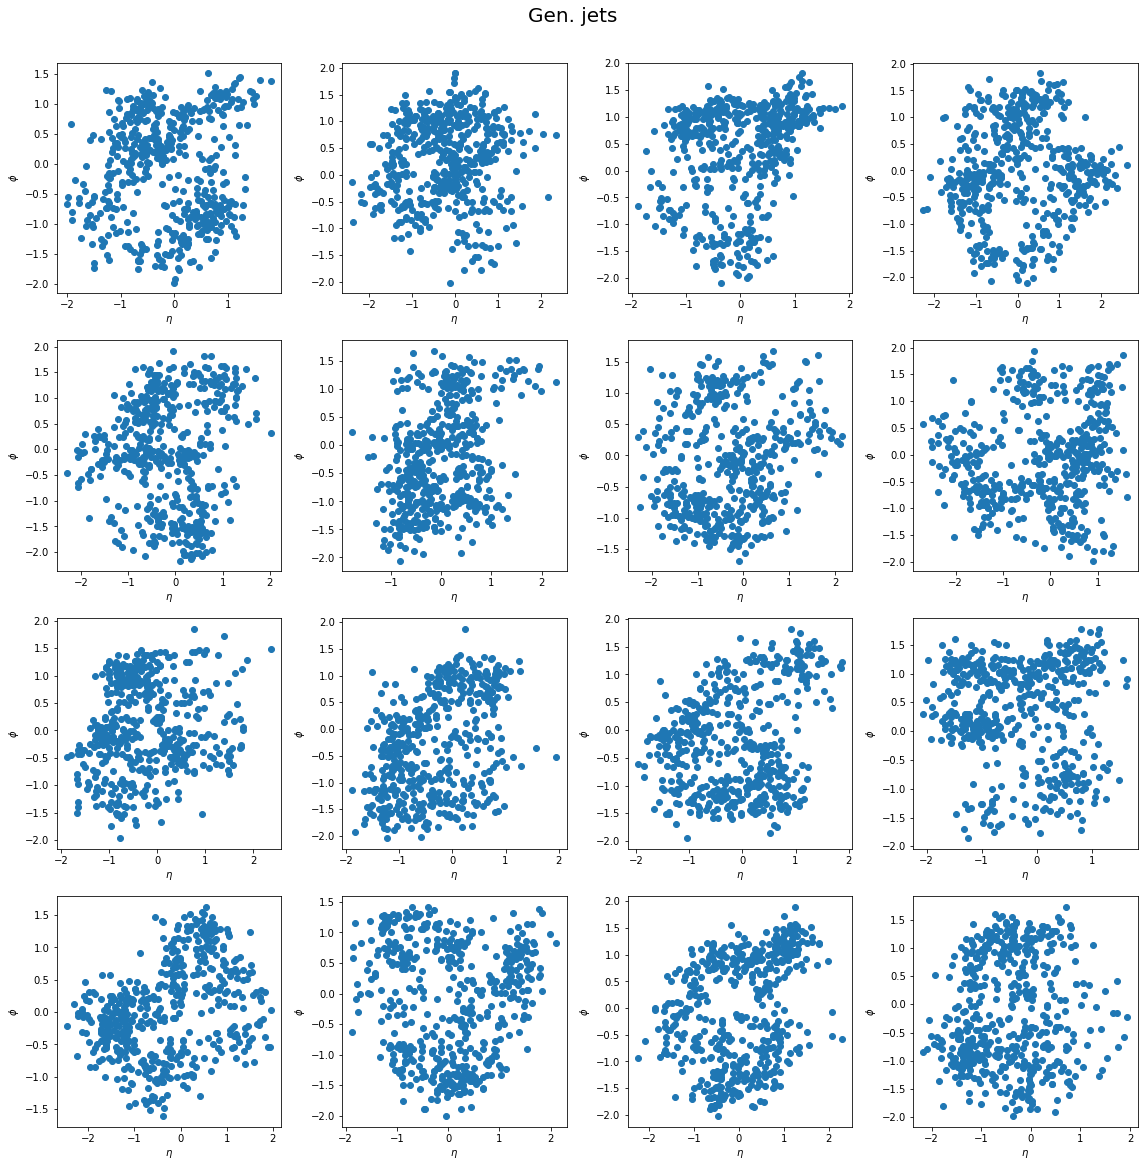

In [35]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(4, 4)

for i in range(16):
    
    ax = fig.add_subplot(gs[i])
    
    ax.scatter(*x_samples[i, :, :2].T)
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    # ax.set_xlim(-0.3, 0.3)
    # ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()